In [1]:
### ----- IMPORT LIBRARIES ----- ###

import numpy as np 
import matplotlib as mpl
from matplotlib import rcParams, rc
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from scipy.interpolate import interp2d
import matplotlib.colors as colors

                
# temp colormap
cm_name = 'lajolla'
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cm_file = np.flip(cm_file, axis=0)
temperature_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

# cloud colormap
cm_name = 'devon' 
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cloud_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[0:240])


plt.style.use('../../Paul_style.txt')
#plt.rcParams["font.family"] = "Serif"

In [3]:
planet_names = [#'HD189-DOGRAY',
                'HD189-DOGRAY-ALL-CLOUDS']
               # 'HD189-DOGRAY-ALL-CLOUDS-COMPACT',
               # 'HD189-DOGRAY-NUC-CLOUDS',
               # 'HD189-DOGRAY-NUC-CLOUDS-COMPACT',
              #  'HD189-PICKET',
              #  'HD189-PICKET-ALL-CLOUDS',
              #  'HD189-PICKET-ALL-CLOUDS-COMPACT',
              #  'HD189-PICKET-NUC-CLOUDS',
              #  'HD189-PICKET-NUC-CLOUDS-COMPACT']
               # 'HD209-DOGRAY',
               # 'HD209-DOGRAY-ALL-CLOUDS',
               # 'HD209-DOGRAY-ALL-CLOUDS-COMPACT',
               # 'HD209-DOGRAY-NUC-CLOUDS',
               # 'HD209-DOGRAY-NUC-CLOUDS-COMPACT',
               # 'HD209-PICKET',
               # 'HD209-PICKET-ALL-CLOUDS',
              #  'HD209-PICKET-ALL-CLOUDS-COMPACT']
               # 'HD209-PICKET-NUC-CLOUDS',
               # 'HD209-PICKET-NUC-CLOUDS-COMPACT']
                
P_phots = [0.141]
           #0.141,
           #0.141,
           #0.141,
           #0.141,
           #0.141]
         #  0.061,
         #  0.061]
         #  0.061,
         #  0.061,
         #  0.061,
         #  0.061]


#planet_names = ['HD209-DOGRAY-NUC-CLOUDS','HD209-PICKET-NUC-CLOUDS']         
#P_phots = [0.001, 0.001]

## The way we graph these we need to double the data.
## Not good code

In [4]:


column_names = ['lat', 'lon', 'level',
               'alt', 'pres', 'temp', 
                'u', 'v', 'w',
                'aero_tau_pre_qext_1', 'sw_asym_1', 'sw_pi0_1',
                'aero_tau_pre_qext_2', 'sw_asym_2', 'sw_pi0_2',
                'aero_tau_pre_qext_3', 'sw_asym_3', 'sw_pi0_3',
                'aero_tau_pre_qext_4', 'sw_asym_4', 'sw_pi0_4',
                'aero_tau_pre_qext_5', 'sw_asym_5', 'sw_pi0_5',
                'aero_tau_pre_qext_6', 'sw_asym_6', 'sw_pi0_6',
                'aero_tau_pre_qext_7', 'sw_asym_7', 'sw_pi0_7',
                'aero_tau_pre_qext_8', 'sw_asym_8', 'sw_pi0_8',
                'aero_tau_pre_qext_9', 'sw_asym_9', 'sw_pi0_9',
                'aero_tau_pre_qext_10', 'sw_asym_10', 'sw_pi0_10',
                'aero_tau_pre_qext_11', 'sw_asym_11', 'sw_pi0_11',
                'aero_tau_pre_qext_12', 'sw_asym_12', 'sw_pi0_12',
                'aero_tau_pre_qext_13', 'sw_asym_13', 'sw_pi0_13',
                'haze_tau_optical_depth_per_bar', 'haze_asym', 'haze_pi0']
nlat = 48
nlon = 193
nlevel = 50
nparams = 51    
    
for planet_name in planet_names:
    df = pd.read_csv('../Spectral-Processing/GCM-OUTPUT/' + planet_name + '_with_clouds_and_wavelength_dependence' + '.txt', delim_whitespace=True, names=column_names)

    # Double the data
    double = df.copy()
    double.lon = double.lon + 360.0

    double2 = df.copy()
    double2 = double2[(double2['lon'] == 0.0)]
    double2.lon = double2.lon + 720.0

    doubled = pd.concat([df, double, double2])
    doubled = doubled.sort_values(by=['lat', 'lon', 'level'], axis=0, ascending=[True, True, True])

    numpy_df = doubled.to_numpy()
    np.savetxt('../Spectral-Processing/GCM-OUTPUT/' + planet_name + '_with_clouds_and_wavelength_dependence' + '_doubled.txt', numpy_df,
            fmt=' '.join(['%5.2f']*2 + ['%3d']*1 + ['%9.2E']*6 + ['%9.2E']*42 + ['\t']))

Calculating T and aerosol tau...


<Figure size 3600x2400 with 0 Axes>

<Figure size 3600x2700 with 0 Axes>

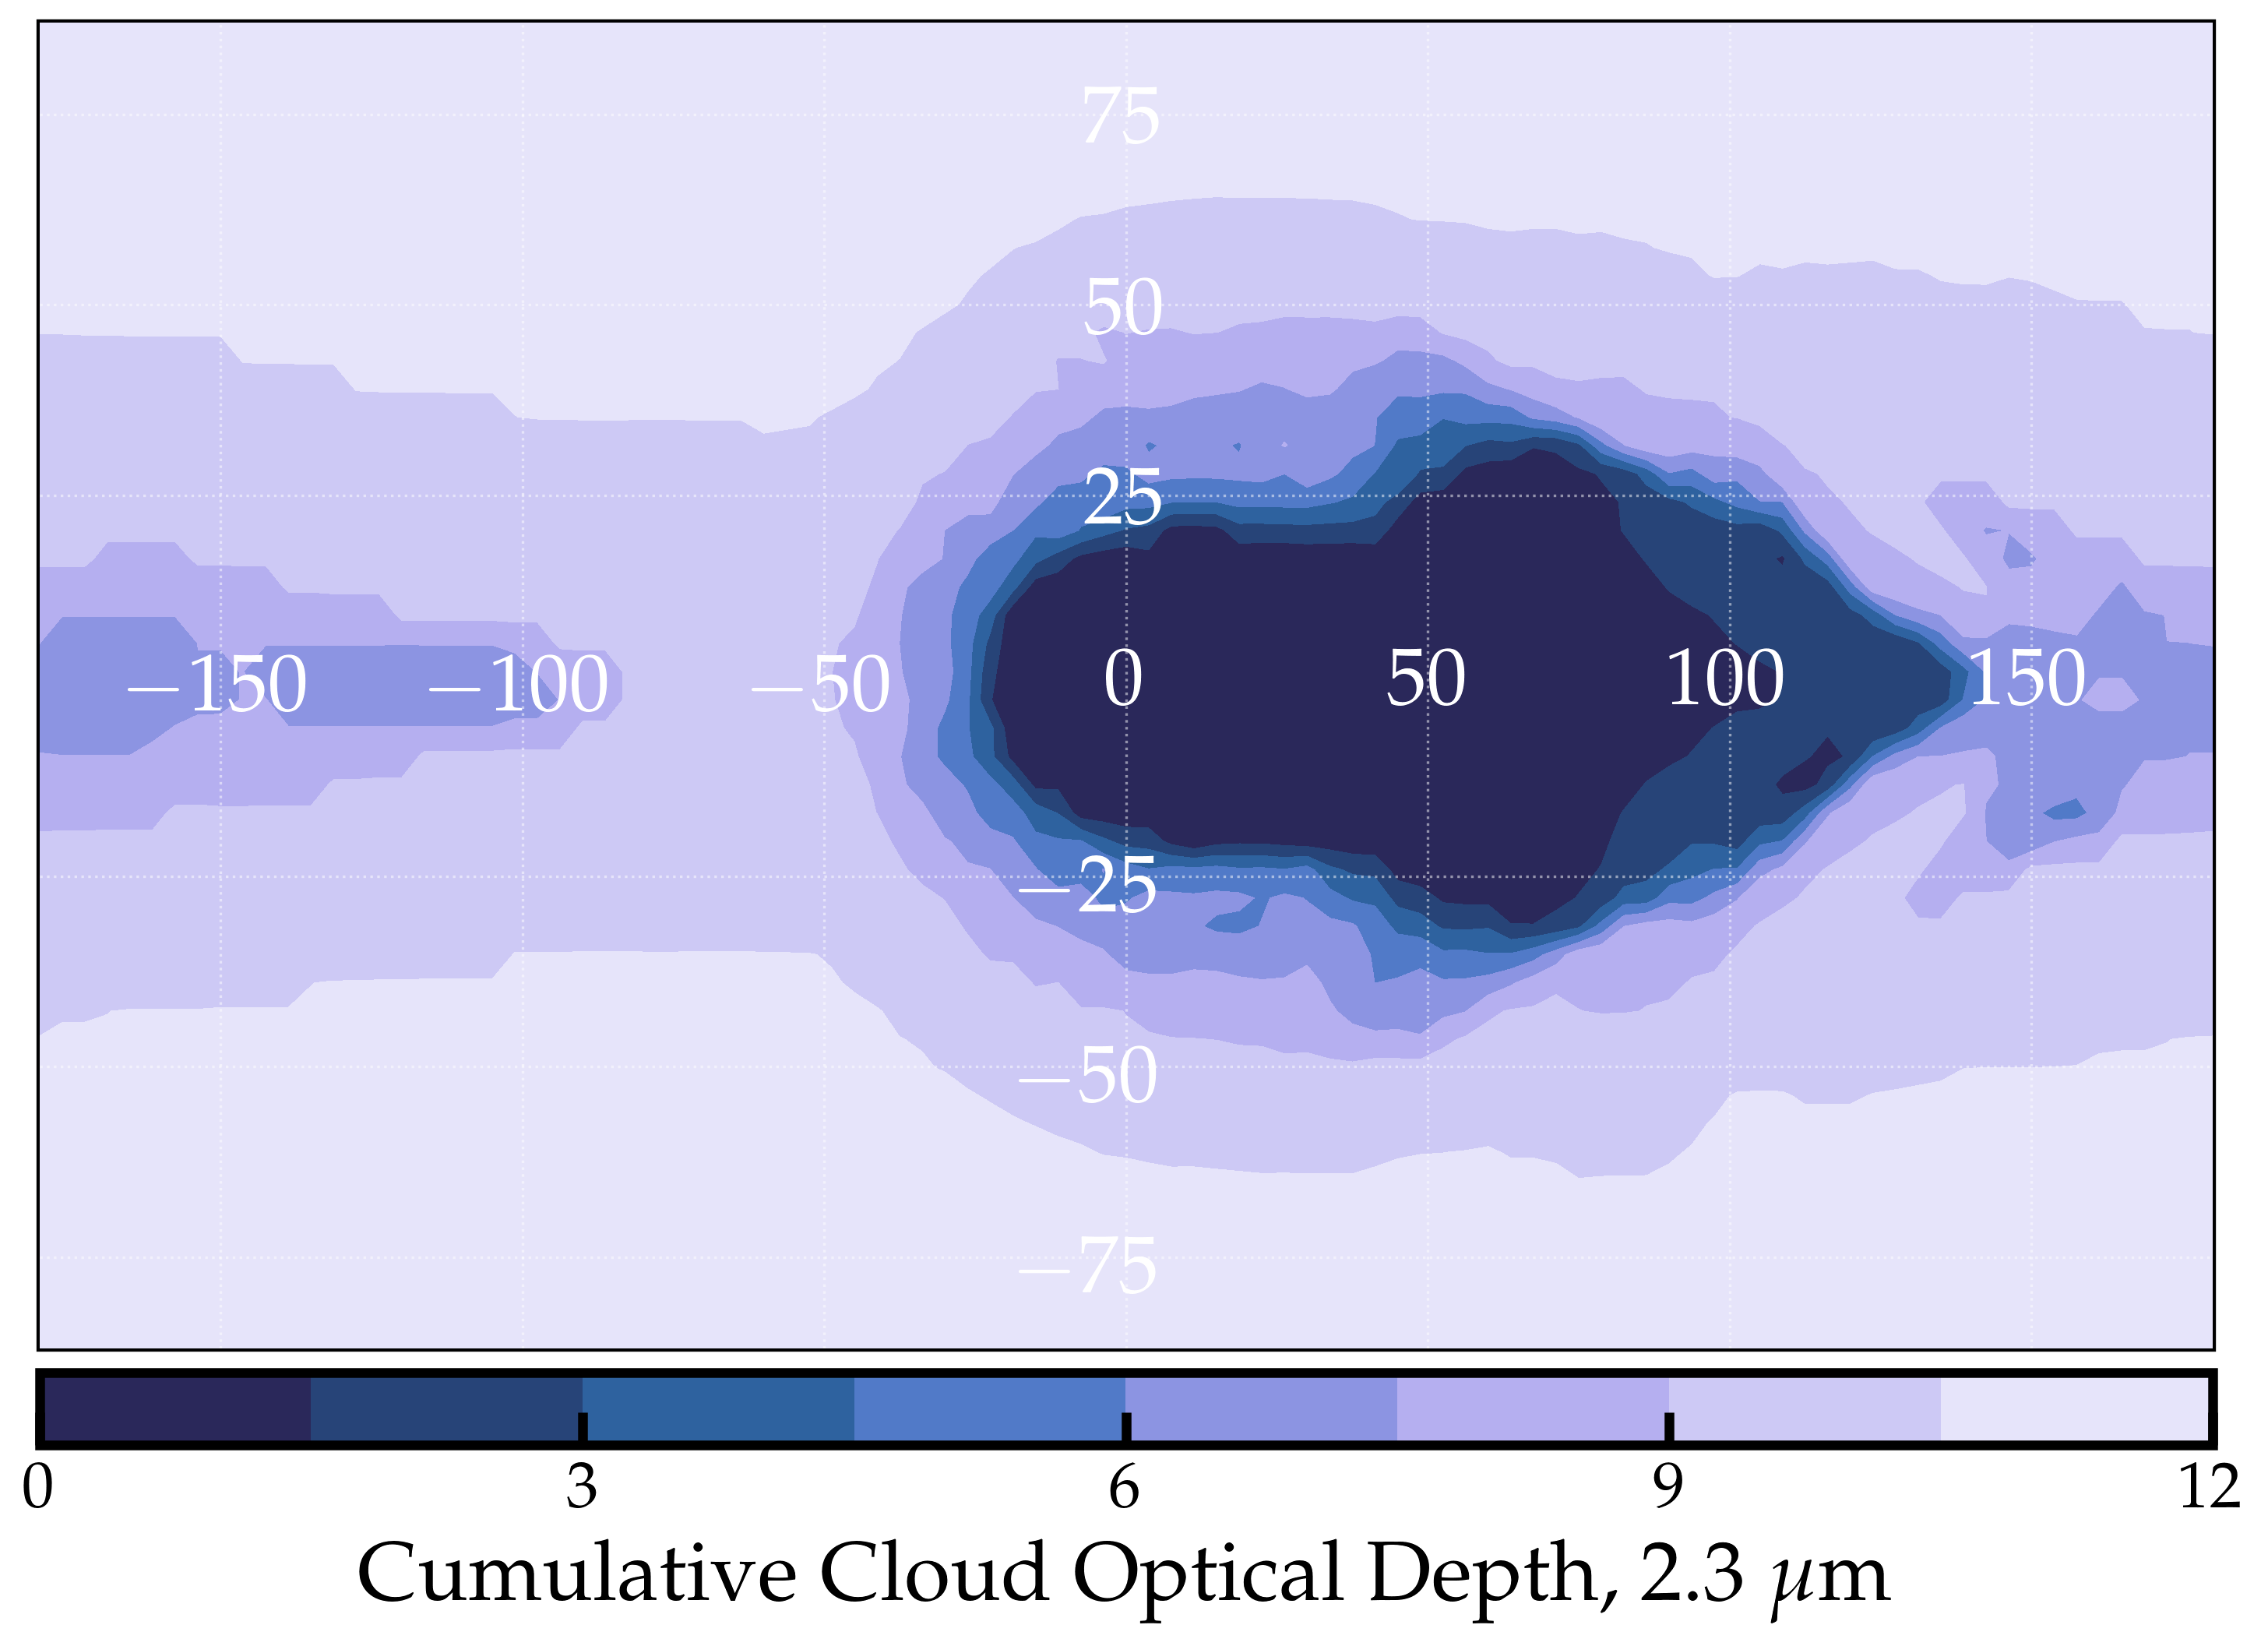

In [5]:
### ----- INPUT/OUTPUT CONTROL ----- ###



for ind, planet_name in enumerate(planet_names):
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,9))
    plt.subplots_adjust(wspace=0.01, hspace=0.015)

    P_phot = P_phots[ind]
        
    data = np.loadtxt('../Spectral-Processing/GCM-OUTPUT/' + planet_name + '_with_clouds_and_wavelength_dependence_doubled.txt')
    data = data.reshape((nlat, nlon, nlevel, nparams))
    
    # need to get indices for given pressure level
    pressure_ind = np.zeros((nlat, nlon))

    for i in range(nlat):
        for j in range(nlon):
            k = nlevel - 1

            while data[i][j][k][4] > P_phot:
                k -= 1
            pressure_ind[i][j] = k
            
        lons = data[:,:,0,1][0] - 360
    lats = data[:,:,0,0][:,0]
    

    ### ----- GET LOCAL TEMP, AEROSOL TAU, etc... ----- ###

    print('Calculating T and aerosol tau...')

    temps = np.zeros((nlat, nlon))
    taus1 = np.zeros((nlat, nlon))
    taus2 = np.zeros((nlat, nlon))
    taus3 = np.zeros((nlat, nlon))
    taus4 = np.zeros((nlat, nlon))
    taus5 = np.zeros((nlat, nlon))
    taus6 = np.zeros((nlat, nlon))
    taus7 = np.zeros((nlat, nlon))
    taus8 = np.zeros((nlat, nlon))
    taus9 = np.zeros((nlat, nlon))
    taus10 = np.zeros((nlat, nlon))
    taus11 = np.zeros((nlat, nlon))
    taus12 = np.zeros((nlat, nlon))
    taus13 = np.zeros((nlat, nlon))
    EW_vels = np.zeros((nlat, nlon))
    NS_vels = np.zeros((nlat, nlon))
    vert_vels = np.zeros((nlat, nlon))
    pressures = np.zeros((nlat, nlon))
    z = np.zeros((nlat, nlon))

    ### ----- CALCULATE TEMP INVERSIONS FOR PLOTTING ----- ###

    # empty array to store values
    delta_temps = np.zeros((nlat, nlon))
    taus = np.zeros((nlat, nlon))

    for i in range(nlat):
        for j in range(nlon):

            z[i][j] = data[i][j][int(pressure_ind[i][j])][3]
            pressures[i][j] = data[i][j][int(pressure_ind[i][j])][4]
            temps[i][j] = data[i][j][int(pressure_ind[i][j])][5]
            EW_vels[i][j] = data[i][j][int(pressure_ind[i][j])][6]
            NS_vels[i][j] = data[i][j][int(pressure_ind[i][j])][7]
            vert_vels[i][j] = data[i][j][int(pressure_ind[i][j])][8]


            # integrate aerosol optical depth above pressure level
            k = 0

            while k <= int(pressure_ind[i][j]):                
                taus1[i][j] += data[i][j][k][9]
                taus1[i][j] += data[i][j][k][12]
                taus1[i][j] += data[i][j][k][15]
                taus1[i][j] += data[i][j][k][18]
                
                taus1[i][j] += data[i][j][k][21]
                taus1[i][j] += data[i][j][k][24]
                taus1[i][j] += data[i][j][k][27]
                taus1[i][j] += data[i][j][k][30]
                
                taus1[i][j] += data[i][j][k][33]
                taus1[i][j] += data[i][j][k][36]
                taus1[i][j] += data[i][j][k][39]
                taus1[i][j] += data[i][j][k][42]
                
                taus1[i][j] += data[i][j][k][45]
                
                
                # The hazes are optical depth per bar
                #taus1[i][j] += data[i][j][k][48] * (data[i][j][k+1][4] - data[i][j][k][4])            
                
                # The clouds have extremely high optical depths
                k += 1
                
    # stream plot
    test_x = np.linspace(min(lons), max(lons), len(lons))
    test_y = np.linspace(min(lats), max(lats), len(lats))

    #if 'HD189' in planet_name:
    #    temp_map = axes.contourf(lons, lats, temps, cmap=temperature_colors, levels=np.linspace(400, 1700, 100)) 
    #else:
    #    temp_map = axes.contourf(lons, lats, temps, cmap=temperature_colors, levels=np.linspace(700, 2000, 100)) 

    if 'HD189' in planet_name:
        temp_map = axes.contourf(lons, lats, temps, cmap=temperature_colors, levels=np.linspace(400, 1700, 100)) 
    else:
        temp_map = axes.contourf(lons, lats, temps, cmap=temperature_colors, levels=np.linspace(400, 2000, 100)) 
                
    flow = axes.streamplot(test_x, test_y, EW_vels, NS_vels, linewidth=1.2,density=([1,1.5]),color='#d8dcd6', zorder=1)
    
    #cloud_map = axes[1].contourf(lons, lats, taus1, cmap=cloud_colors)
    

    # format axes
    #for ax in axes:#.flatten():
    axes.set_xlim([-180, 180])
    axes.set_ylim([-87, 87])
    axes.spines['left'].set_position('zero')
    axes.spines['bottom'].set_position('zero')
    axes.spines['left'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['top'].set_color('none')
    axes.spines['bottom'].set_color('none')
    axes.tick_params(
        axis='both',
        which='both',
        top=False,
        bottom=False,
        right=False,
        left=False,
        labelcolor='w',
        labelsize=25,
        pad=-12)
    #axes.yaxis.get_major_ticks()[2].label1.set_visible(False)
    axes.set_yticks([-75, -50, -25, 25, 50, 75])
    axes.grid(color='w', alpha=0.5, ls=':')


    axes.patch.set_edgecolor('black')  
    axes.patch.set_linewidth('2')  
    axes.grid(color='w', alpha=0.5, ls=':')

    
    temp_cbar = fig.colorbar(temp_map, aspect=30, pad=0.015, orientation = 'horizontal') #ax=axes.ravel().tolist(),
    temp_cbar.set_label('Temperature (K)', fontsize=26)


    plt.savefig('../Figures/Temperature_Isobars_{}_bar_{}.png'.format(P_phots[ind], planet_name), bbox_inches='tight', dpi=250)
    
    
    if 'CLOUDS' in planet_name:
        plt.clf()
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,9))
        plt.subplots_adjust(wspace=0.01, hspace=0.015)

        cloud_map = axes.contourf(lons, lats, taus1, cmap=cloud_colors)

        # format axes
        #for ax in axes:#.flatten():
        axes.set_xlim([-180, 180])
        axes.set_ylim([-87, 87])
        axes.spines['left'].set_position('zero')
        axes.spines['bottom'].set_position('zero')
        axes.spines['left'].set_color('none')
        axes.spines['right'].set_color('none')
        axes.spines['top'].set_color('none')
        axes.spines['bottom'].set_color('none')
        axes.tick_params(
            axis='both',
            which='both',
            top=False,
            bottom=False,
            right=False,
            left=False,
            labelcolor='w',
            labelsize=25,
            pad=-12)
        #axes.yaxis.get_major_ticks()[2].label1.set_visible(False)
        axes.set_yticks([-75, -50, -25, 25, 50, 75])
        axes.grid(color='w', alpha=0.5, ls=':')


        axes.set_yticks([-75, -50, -25, 25, 50, 75])
        axes.grid(color='w', alpha=0.5, ls=':')


        axes.patch.set_edgecolor('black')  
        axes.patch.set_linewidth('2')  
        axes.grid(color='w', alpha=0.5, ls=':')

        cloud_cbar = fig.colorbar(cloud_map, aspect=30, pad=0.015, orientation = 'horizontal')
        cloud_cbar.set_label('Cumulative Cloud Optical Depth, 2.3 $\\mu$m', fontsize=26)
        cloud_cbar.ax.locator_params(nbins=5)


        plt.savefig('../Figures/Cloud_Coverage_Isobars_{}_bar_{}.png'.format(P_phots[ind], planet_name), bbox_inches='tight', dpi=250)